# Housing Prices Competition for Kaggle Learners
### Practice Notebook to submit

The competition is about predict the SalesPrices of Houses in the X_test dataset with a machine learning model with low Mean Squared Error as possible.

Ensure that the dataset is loaded to the notebook, adding data in the right tag. Search by "Housing Prices..." in the competition datasets, and load it.

<div>
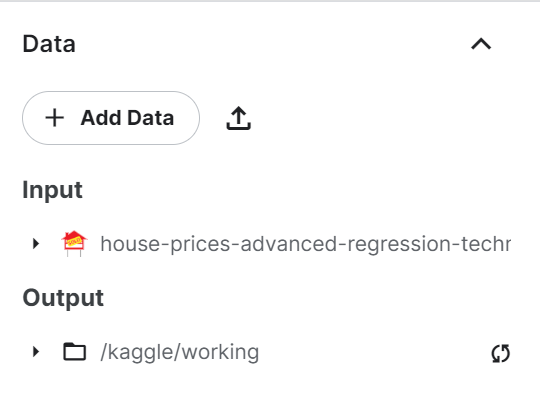
</div>


## Modules
Import the needed libraries for the model

In [123]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

## A bit of feature engineering practices
I will try to find the better features for training the model and improve the performance and quality of learning of the model

In [124]:
# Configurations for graphs
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [125]:
# Calculate the MI of every feature with the target
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# graph for comparition of MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

### investigating the relation between fuatures

In [126]:
X_full = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() < 10 and 
                    X_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X = X_full[my_cols].copy()

In [127]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='most_frequent')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocessing
clear_X = pd.DataFrame(clf.fit_transform(X, y))
clear_X.columns = X.columns
clear_X

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,5.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1456,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1457,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,0.0,2.0,8.0,4.0
1458,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0


None
['Foundation', 'PoolQC', 'GarageQual', 'PavedDrive', 'BsmtFinSF2', 'LotFrontage', 'ScreenPorch', 'MiscVal']


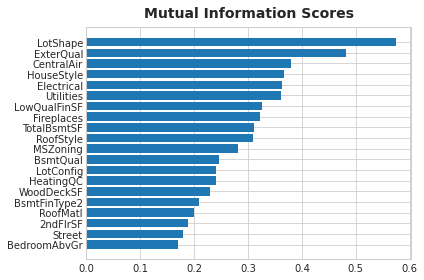

In [128]:
mi_scores = make_mi_scores(clear_X, y)
print(plot_mi_scores(mi_scores.head(20)))
bad_features = mi_scores.tail(8).index.to_list()
print(bad_features)

# Training the model
### Preprocess the data
Handling data and spliting the dataset

In [129]:
# Read the data
X_full = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
X_test_full = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors, remove irrelevant columns
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# remove bad features
X_full.drop(bad_features, axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y,
                                                                train_size=0.85, test_size=0.15,
                                                                random_state=1)

# Select categorical columns with relatively low cardinality
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

### Visualize the data
A view of how thw data is ordered in the data set, seeing the columns and values that are available

In [130]:
X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
76,180,1596,4,5,1973,1973,0.0,462,0,462,...,0,0,0,1,0,0,0,0,1,0
1183,60,15623,10,5,1996,1996,0.0,2096,300,2396,...,0,0,0,1,1,0,0,0,0,0
463,20,8281,5,5,1965,1965,0.0,553,0,864,...,0,0,0,1,0,0,0,0,1,0
756,160,3230,6,5,1999,1999,894.0,381,348,729,...,0,0,0,1,0,0,0,0,1,0
1356,80,10192,7,6,1968,1992,143.0,0,570,570,...,0,0,0,1,0,0,0,0,1,0


### Perform the score with an Extreme Gradient Boosting model
This update use a new model that optimize the loss by gradient descent method

In [131]:
# Define the model
my_model = XGBRegressor(n_estimators=650, learning_rate=0.02)

# Fit the model
my_model.fit(X_train, y_train)

# Get predictions
predictions = my_model.predict(X_valid)

# Calculate MAE
mae = mean_absolute_error(predictions, y_valid)
print("Mean Absolute Error:" , mae)

# best record: 13250.70

Mean Absolute Error: 13250.70888627283


### Generate Predictions with the X_test dataset
we will generate the columns target with predictions of the model

In [132]:
preds_test = my_model.predict(X_test)
preds_test

array([116589.82, 155513.14, 183096.08, ..., 165973.5 , 115227.81,
       222739.22], dtype=float32)

### Output file to submit
When I have the lowest score that I can find, we define the model as well and train the final model, and summit the predictions to the competition.

In [133]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)